## Ex1: Handwritten Digit Recognition

In this tutorial we will go through the basic use case of MXNet and also touch on some advanced usages. This example is based on the MNIST dataset, which contains 70,000 images of hand written characters with 28-by-28 pixel size.

This tutorial covers the following topics:
- network definition.
- Variable naming.
- Basic data loading and training with feed-forward deep neural networks.
- Monitoring intermediate outputs for debuging.
- Custom training loop for advanced models.


In [1]:
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging


### Network Definition
Now we can start constructing our basic network, multilayer percepton:

In [2]:
#Create a multilayer pecepton   
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, 
#    the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

We can visualize the network we just defined with MXNet's visualization module:

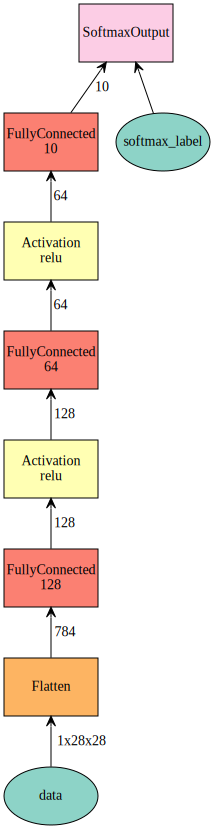

In [3]:
# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (100, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

### Variable Naming

MXNet requires variable names to follow certain conventions:
- All input arrays have a name. This includes inputs (data & label) and model parameters (weight, bias, etc).
- Arrays can be renamed by creating named variable. Otherwise, a default name is given as 'SymbolName_ArrayName'. For example, FullyConnected symbol fc1's weight array is named as 'fc1_weight'.
- Although you can also rename weight arrays with variables, weight array's name should always end with '_weight' and bias array '_bias'. MXNet relies on the suffixes of array names to correctly initialize & update them.

Call list_arguments method on a symbol to get the names of all its inputs:

In [4]:
mlp.list_arguments()

['data',
 'fc1_weight',
 'fc1_bias',
 'fc2_weight',
 'fc2_bias',
 'fc3_weight',
 'fc3_bias',
 'softmax_label']

### Data Loading and Preparation 

We fetch and load the MNIST dataset including training and test dataset. We also visualize a few examples to get an idea of what the dataset looks like.

In [5]:
# Download and load the dataset 
import numpy as np
import os
import urllib
import gzip
import struct
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

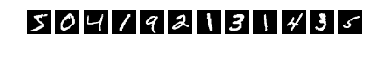

label: [5 0 4 1 9 2 1 3 1 4 3 5]


In [6]:
# Show some samples of the pictures 
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(12):
    plt.subplot(1,12,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:12],))

Now we can create data iterators from our MNIST data. A data iterator returns a batch of data examples each time for the network to process. MXNet provide a suite of basic DataIters for parsing different data format. Here we use NDArrayIter, which wraps around a numpy array and each time slice a chunk from it along the first dimension.

In [7]:
#Convert the data into the format used for MxNet's NN 
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

### Training

With the network and data source defined, we can finally start to train our model. We do this with MXNet's convenience wrapper for feed forward neural networks (it can also be made to handle RNNs with explicit unrolling). 

In [20]:
# Train and validate the model with the training sample 
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    ctx = mx.cpu(0),      # Run on CPU 0; changed into gpu if gpu used 
    symbol = mlp,         # Use the network we just defined
    num_epoch = 10,       # Train for 10 epochs
    learning_rate = 0.1,  # Learning rate
    momentum = 0.9,       # Momentum for SGD with momentum
    wd = 0.00001)         # Weight decay for regularization
model.fit(
    X=train_iter,  # Training data set
    eval_data=val_iter,  # Testing data set. MXNet computes scores on test set every epoch
    batch_end_callback = mx.callback.Speedometer(batch_size, 200))  # Logging module to print out progress

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 10655.43 samples/sec	Train-accuracy=0.428500
INFO:root:Epoch[0] Batch [400]	Speed: 11240.70 samples/sec	Train-accuracy=0.910800
INFO:root:Epoch[0] Batch [600]	Speed: 11095.77 samples/sec	Train-accuracy=0.938200
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=5.472
INFO:root:Epoch[0] Validation-accuracy=0.954200
INFO:root:Epoch[1] Batch [200]	Speed: 11196.74 samples/sec	Train-accuracy=0.950150
INFO:root:Epoch[1] Batch [400]	Speed: 11133.18 samples/sec	Train-accuracy=0.961500
INFO:root:Epoch[1] Batch [600]	Speed: 11172.19 samples/sec	Train-accuracy=0.963600
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=5.386
INFO:root:Epoch[1] Validation-accuracy=0.963000
INFO:root:Epoch[2] Batch [200]	Speed: 11240.06 samples/sec	Train-accuracy=0.968500
INFO:root:Epoch[2] Batch [400]	Speed: 11015.39 samples/sec	Train-accuracy=0.970800
INFO:root:Epoch[2] Batch [600]	Speed: 11163.54 samples/sec	Train-accuracy=0.973550
I

### Evaluation

After the model is trained, we can evaluate it on a held out test set.
First, lets classity a sample image:

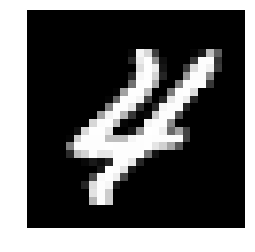

Classified as 4 with probability 0.999998


In [21]:
# Show one result of the validated dataset 
import random 
index=random.randint(0,len(val_img))
plt.imshow(val_img[index], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(val_img[index:(index+1)].astype(np.float32)/255)[0]
assert max(prob) > 0.99, "Low prediction accuracy for id "+str(index)+"; prob:"+str(max(prob))
print 'Classified as %d with probability %f' % (prob.argmax(), max(prob))

We can also evaluate the model's accuracy on the entire test set:

In [22]:
print 'Accuracy:', model.score(val_iter)*100, '%'

Accuracy: 97.08 %


Now, try if your model recognizes your own hand writing.
Write a digit from 0 to 9 in the box below. Try to put your digit in the middle of the box.

In [23]:
# run hand drawing test
from IPython.display import HTML

def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1, 784))/255.0
    return model.predict(img)[0].argmax()

html = """<style type="text/css">canvas { border: 1px solid black; }</style><div id="board"><canvas id="myCanvas" width="100px" height="100px">Sorry, your browser doesn't support canvas technology.</canvas><p><button id="classify" onclick="classify()">Classify</button><button id="clear" onclick="myClear()">Clear</button>Result: <input type="text" id="result_output" size="5" value=""></p></div>"""
script = """<script type="text/JavaScript" src="https://ajax.googleapis.com/ajax/libs/jquery/1.4.2/jquery.min.js?ver=1.4.2"></script><script type="text/javascript">function init() {var myCanvas = document.getElementById("myCanvas");var curColor = $('#selectColor option:selected').val();if(myCanvas){var isDown = false;var ctx = myCanvas.getContext("2d");var canvasX, canvasY;ctx.lineWidth = 8;$(myCanvas).mousedown(function(e){isDown = true;ctx.beginPath();var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.moveTo(canvasX, canvasY);}).mousemove(function(e){if(isDown != false) {var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.lineTo(canvasX, canvasY);ctx.strokeStyle = curColor;ctx.stroke();}}).mouseup(function(e){isDown = false;ctx.closePath();});}$('#selectColor').change(function () {curColor = $('#selectColor option:selected').val();});}init();function handle_output(out) {document.getElementById("result_output").value = out.content.data["text/plain"];}function classify() {var kernel = IPython.notebook.kernel;var myCanvas = document.getElementById("myCanvas");data = myCanvas.toDataURL('image/png');document.getElementById("result_output").value = "";kernel.execute("classify('" + data +"')",  { 'iopub' : {'output' : handle_output}}, {silent:false});}function myClear() {var myCanvas = document.getElementById("myCanvas");myCanvas.getContext("2d").clearRect(0, 0, myCanvas.width, myCanvas.height);}</script>"""
HTML(html+script)

### Debugging

DNNs can perform poorly for a lot of reasons, like learning rate too big/small, initialization too big/small, network structure not reasonable, etc. When this happens it's often helpful to print out the weights and intermediate outputs to understand what's going on. MXNet provides a monitor utility that does this:

In [13]:
def norm_stat(d):
    """The statistics you want to see.
    We compute the L2 norm here but you can change it to anything you like."""
    return mx.nd.norm(d)/np.sqrt(d.size)
mon = mx.mon.Monitor(
    100,                 # Print every 100 batches
    norm_stat,           # The statistics function defined above
    pattern='.*weight',  # A regular expression. Only arrays with name matching this pattern will be included.
    sort=True)           # Sort output by name
model = mx.model.FeedForward(ctx = mx.cpu(), symbol = mlp, num_epoch = 1,
                             learning_rate = 0.1, momentum = 0.9, wd = 0.00001)
model.fit(X=train_iter, eval_data=val_iter, monitor=mon,  # Set the monitor here
          batch_end_callback = mx.callback.Speedometer(100, 100))

INFO:root:Start training with [cpu(0)]
INFO:root:Batch:       1 fc1_backward_weight            0.000549398	
INFO:root:Batch:       1 fc1_weight                     0.00577777	
INFO:root:Batch:       1 fc2_backward_weight            0.00235746	
INFO:root:Batch:       1 fc2_weight                     0.00577121	
INFO:root:Batch:       1 fc3_backward_weight            0.00775901	
INFO:root:Batch:       1 fc3_weight                     0.00581161	


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [100]	Speed: 24662.25 samples/sec	Train-accuracy=0.139900
INFO:root:Batch:     101 fc1_backward_weight            0.0955087	
INFO:root:Batch:     101 fc1_weight                     0.00774271	
INFO:root:Batch:     101 fc2_backward_weight            0.219924	
INFO:root:Batch:     101 fc2_weight                     0.0189555	
INFO:root:Batch:     101 fc3_backward_weight            1.92978	
INFO:root:Batch:     101 fc3_weight                     0.0691224	
INFO:root:Epoch[0] Batch [200]	Speed: 26788.53 samples/sec	Train-accuracy=0.713400
INFO:root:Batch:     201 fc1_backward_weight            0.276595	
INFO:root:Batch:     201 fc1_weight                     0.0224679	
INFO:root:Batch:     201 fc2_backward_weight            0.705773	
INFO:root:Batch:     201 fc2_weight                     0.0487102	
INFO:root:Batch:     201 fc3_backward_weight            2.40022	
INFO:root:Batch:     201 fc3_weight                     0.219382	
INFO:root:Epoch[0] Batch [300]	Speed:

### Convolutional Neural Networks

Note that the previous fully-connected layer simply reshapes the image into a vector during training. It ignores the spatial information that pixels are correlated on both horizontal and vertical dimensions. The convolutional layer aims to improve this drawback by using a more structural weight $W$. Instead of simply matrix-matrix multiplication, it uses 2-D convolution to obtain the output.
<img src="https://thatindiandude.github.io/images/conv.png"> 
We can also have multiple feature maps, each with their own weight matrices, to capture different features:  
<img src="https://thatindiandude.github.io/images/filters.png">  
Besides the convolutional layer, another major change of the convolutional neural network is the adding of pooling layers. A pooling layer reduce a $n\times m$ (often called kernal size) image patch into a single value to make the network less sensitive to the spatial location. 
<img src="https://thatindiandude.github.io/images/pooling.png">
Then, we can use dropout before fully-linked layer to reduce the overfitting and increase robustness for NN. 

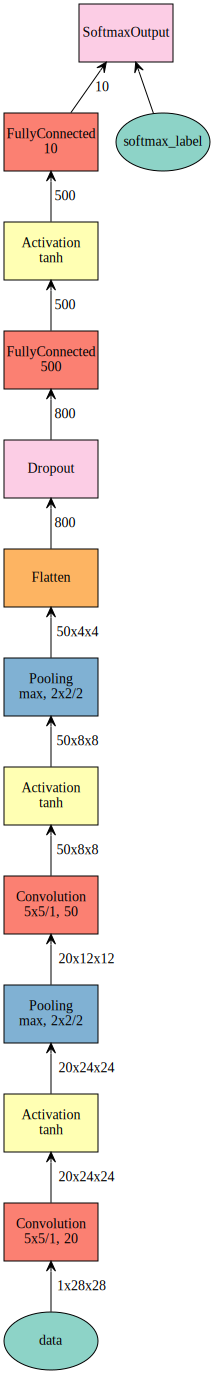

In [15]:
#Create a CNN, you can design your own CNN   
def dmnistCNN():
    data = mx.symbol.Variable('data')
    # first conv layer
    conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
    pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # second conv layer
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
    pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # first fullc layer
    flatten = mx.sym.Flatten(data=pool2)
    flatten = mx.sym.Dropout(data=flatten, p=0.5)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
    
    # third fullc
    fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
    # softmax loss
    lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
    return lenet 

lenet=dmnistCNN()
mx.viz.plot_network(symbol=lenet, shape=shape)

In [17]:
## Train the CNN 
model = mx.model.FeedForward(
    ctx = mx.cpu(0),     # use CPU 0 for training if GPU used 
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 
assert model.score(val_iter) > 0.98, "Low validation accuracy."

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 275.64 samples/sec	Train-accuracy=0.107800
INFO:root:Epoch[0] Batch [400]	Speed: 274.55 samples/sec	Train-accuracy=0.114550
INFO:root:Epoch[0] Batch [600]	Speed: 275.23 samples/sec	Train-accuracy=0.112700
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=218.210
INFO:root:Epoch[0] Validation-accuracy=0.113500
INFO:root:Epoch[1] Batch [200]	Speed: 274.46 samples/sec	Train-accuracy=0.342000
INFO:root:Epoch[1] Batch [400]	Speed: 268.72 samples/sec	Train-accuracy=0.870600
INFO:root:Epoch[1] Batch [600]	Speed: 267.61 samples/sec	Train-accuracy=0.914250
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=222.166
INFO:root:Epoch[1] Validation-accuracy=0.946700
INFO:root:Epoch[2] Batch [200]	Speed: 268.92 samples/sec	Train-accuracy=0.939050
INFO:root:Epoch[2] Batch [400]	Speed: 267.18 samples/sec	Train-accuracy=0.950750
INFO:root:Epoch[2] Batch [600]	Speed: 266.32 samples/sec	Train-accuracy=0.954650
INFO:root:Epoch

In [19]:
# Save the model for later load 
prefix = 'mnistmodel'
iteration = 10
model.save(prefix)
# model_loaded = mx.model.FeedForward.load(prefix, iteration)  


INFO:root:Saved checkpoint to "mnistmodel-0010.params"
